In [2]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import torch

import metrics
import utils

# Introduction

A deep belief network is a generative structured probabilistic model, composed of several layers.  
A DBN can be used to reconstruct the input, each layer acting as a feacture detector.  
A DBN is a sequence of Restricted Botlzmann Machines (RBM) or autoencoders.  
They can be used as an unsupervised technique for pre-training feedforward networks for classification.

# Links

- [Paper - A faster learning algorithm for deep belief nets](http://www.cs.toronto.edu/~hinton/absps/ncfast.pdf)
- [Wikipedia - Deep belief network](https://en.m.wikipedia.org/wiki/Deep_belief_network)
- [Wikipedia - Boltzmann machine](https://en.wikipedia.org/wiki/Boltzmann_machine)
- [Wikipedia - Restricted Boltzmann machine](https://en.m.wikipedia.org/wiki/Restricted_Boltzmann_machine)
- [Paper - The wake-sleep algorithm for unsupervised neural networks](http://www.cs.toronto.edu/~fritz/absps/ws.pdf)

# Boltzmann Machine

A Boltzmann Machine is a graphical model with binary units $s_i \in \{0,1\}$.  
Each edge $s_i$ - $s_j$ is undirected, with weight $w_{ij}$.  

The energy function is:
$$E = - \sum_{i < j} w_{ij} s_i s_j - \sum_{i} \theta_i s_i$$

the weight $w_{ij}$ can be represented ad a symmetric matrix $W$.  
$\theta_i$ represents the bias for unit $s_i$  

In practice, they do not scale well.

# Restricted Botlzmann Machine

RBMs add some restricions on the classiscal Botlzmann Machine:
- the graph is bipartite: the visible units group and the hidden units group.
- they are no connections betweens units of the same group

These resctrictions make it possible to train them more efficiently, usually with the constrastive divergence algorithm.  

The RBM has $m$ visible units $v_i$ and $n$ hidden unit $h_j$. The matrix of weights $W$ associate $w_{ij}$ to weight between $v_i$ and $h_j$.  
We also define the biais weights $a_i$ for the visible units and $b_j$ for the hidden units.  
The enrgy function is defined as:
$$E(v,h) = - \sum_i a_iv_i - \sum_{j} b_j h_j - \sum_i \sum_j w_{ij}v_ih_j$$

The probability of a unit to be activated, given it's predecessors is:
$$P(h_j = 1|v) = \sigma \left( b_j + \sum_i w_{ij}v_i \right)$$
$$P(v_i = 1|h) = \sigma \left( a_i + \sum_j w_{ij}h_j \right)$$

with $\sigma$ the logistic sigmoid function.  

Let's define the probability distribution of the unit in terms of the energy function:
$$P(v,h) = \frac{1}{Z} e^{-E(v,h)}$$
with $Z$ the partition function to ensure that the probability distribution sum to $1$:
$$Z = \sum_{v,h} e^{-E(v,h)}$$

The marginal probability of the visible units is defined by:
$$P(v) = \frac{1}{Z} \sum_{h} e^{-E(v,h)}$$

# Contrastive Divergence

The CD algorithm is an approximation of the maximum likelihood method, who tries to find the weights $W$ that maximizes the log-likelihood of the dataset $V$:

$$W^* = \arg \max_W \mathbb{E}[\log P(v)]$$

The algorithm uses gradient descent:
$$w_{ij} \leftarrow w_{ij} + \epsilon \frac{\partial \log P(v)}{\partial w_{ij}}$$

$$\frac{\partial \log P(v)}{\partial w_{ij}} = \langle v_i h_j \rangle_\text{data} - \langle v_i h_j \rangle_\text{model}$$
with $\langle \text{...} \rangle_p$ average with distribution $p$.

$\langle v_i h_j \rangle_\text{model}$ is computed by using Gibbs sampling for a total of $n$ steps, with usually $n=1$.

The same principle can be applied to update the biases:
$$\frac{\partial \log P(v)}{\partial a_i} = \langle v_i \rangle_\text{data} - \langle v_i \rangle_\text{model}$$
$$\frac{\partial \log P(v)}{\partial b_j} = \langle h_j \rangle_\text{data} - \langle h_j \rangle_\text{model}$$

The algorithm to perform one update is:

1. Take an example vector $v$ from the training set
2. Compute the Bernoulli probability distribution $P(h_j=1|v)$ and sample $h$ from it.
3. Compute the Bernoulli probability distribution $P(v_i=1|h)$ and sample $v'$ from it.
4. Compute the Bernoulli probability distribution $P(h_j=1|v')$ and sample $h'$ from it.
5. Update $W$: $w_{ij} \leftarrow w_{ij} + \epsilon (v_ih_j - v'_ih'_j)$
6. Update $a$: $a_i \leftarrow a_i + \epsilon (v_i - v'_i)$
7. Update $b$: $b_j \leftarrow b_j + \epsilon (h_j - h'_j)$

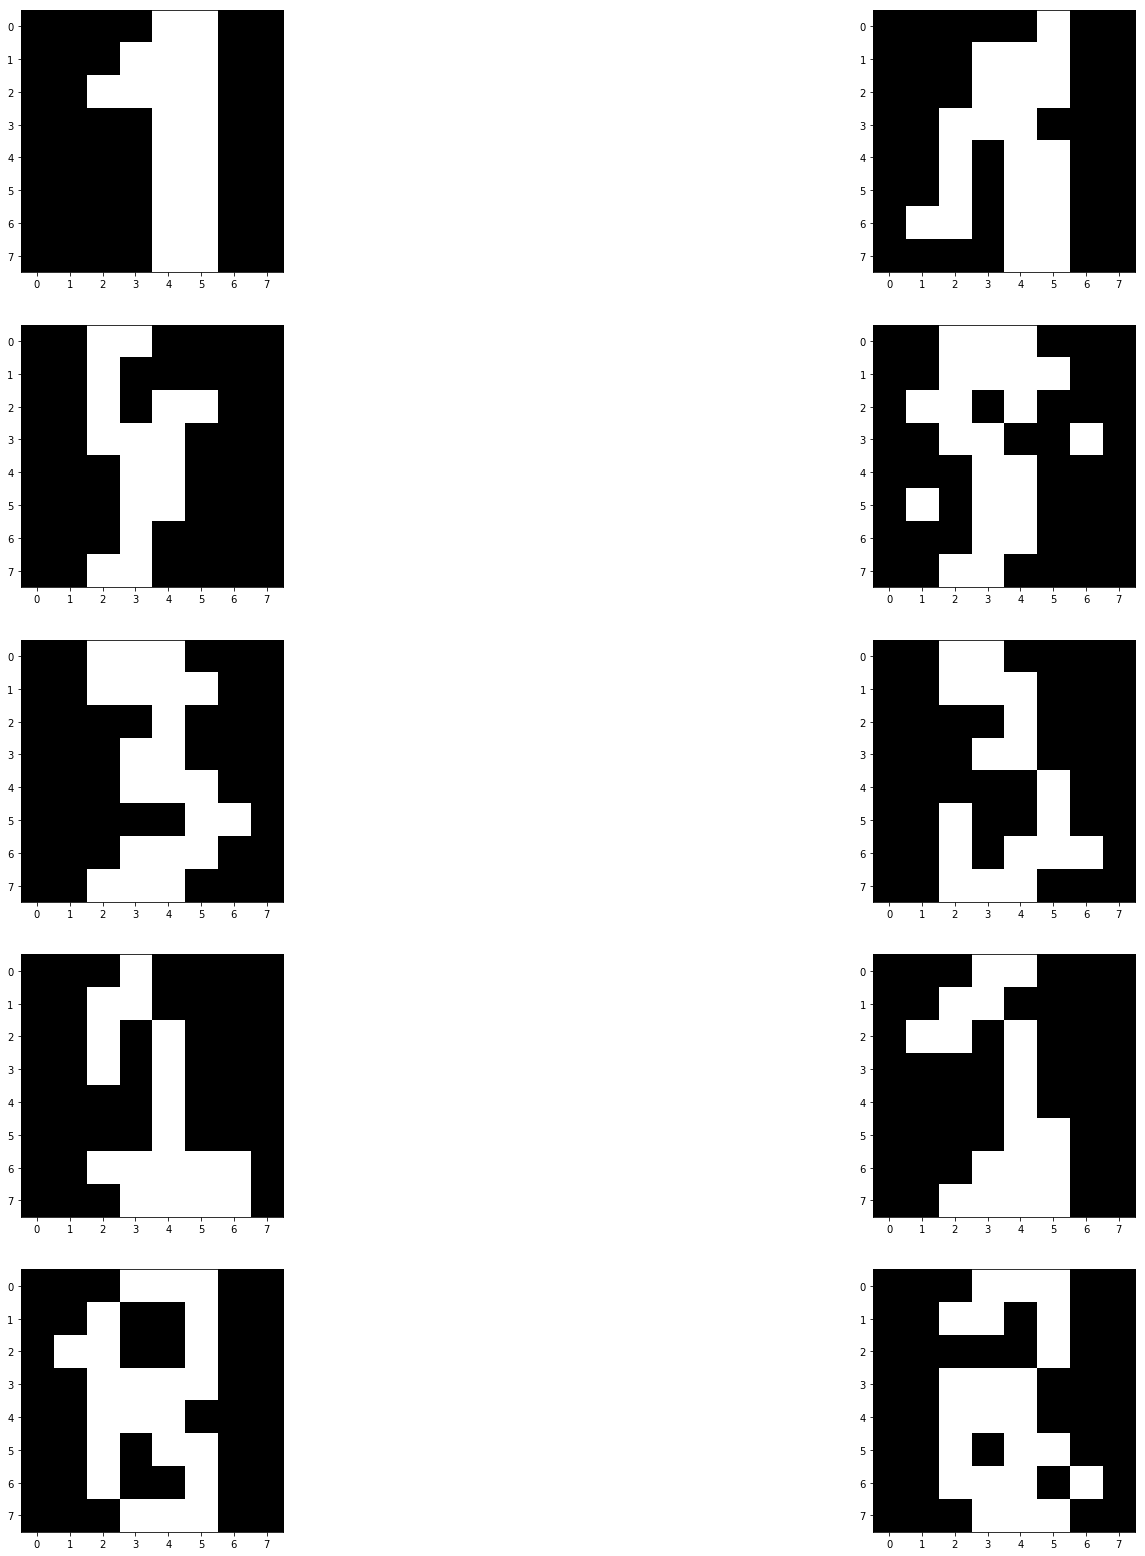

In [66]:
from sklearn.datasets import load_digits

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def binomial_sample(p):
    x = np.random.rand(*p.shape)
    return (x < p).astype(np.int32)
    

class RBM:
    
    def __init__(self, m, n, lr, niters=1000):
        self.m = m
        self.n = n
        self.lr = lr
        self.niters = niters
        self.W = np.random.randn(m, n)
        self.a = np.zeros(m)
        self.b = np.zeros(n)
    
    def get_h_preds(self, v):
        return sigmoid(self.W.T @ v + self.b)
    
    def get_v_preds(self, h):
        return sigmoid(self.W @ h + self.a)
    
    def sample_h_from_v(self, v):
        hp = self.get_h_preds(v)
        return binomial_sample(hp)
    
    def sample_v_from_h(self, h):
        vp = self.get_v_preds(h)
        return binomial_sample(vp)
    
        
    def fit(self, X):
        
        for it in range(self.niters):
            
            v0 = X[np.random.randint(0, len(X))]
            h0p = self.get_h_preds(v0)
            h0 = binomial_sample(h0p)
            v1p = self.get_v_preds(h0)
            v1 = binomial_sample(v1p)
            h1p = self.get_h_preds(v1)
            h1 = binomial_sample(h1p)
            
            gw = np.outer(v0, h0) - np.outer(v1, h1)
            ga = v0 - v1
            gb = h0 - h1
            self.W += self.lr * gw
            self.a += self.lr * ga
            self.b += self.lr * gb



X, y = load_digits().data, load_digits().target
X = (X >= 8).astype(np.int)

mod = RBM(64, 20, lr=1e-2, niters=100000)
mod.fit(X)

fig=plt.figure(figsize=(28, 28))
for i in range(5):
    X0 = X[np.random.randint(0, len(X))]
    X0r = mod.sample_v_from_h(mod.sample_h_from_v(X0))
    fig.add_subplot(5, 2, 2*i+1)
    plt.imshow(X0.reshape(8, 8), cmap='gray')
    fig.add_subplot(5, 2, 2*i+2)
    plt.imshow(X0r.reshape(8, 8), cmap='gray')

plt.show()

# Deep Belief Network

A DBF is a stack of several RBM. They can be trained one at the time, starting by by the one at the bottom, using the dataset input.  
The visible units of the next RBM are the hidden units of the previous ones. It is trained using the hidden representation of the dataset by the preivous layer.  
All layers are trained one by one this way from bottom to top.

# The Up-down algortihm

Once the RBM are trained, the weights can be optimized altogether, using the up-down algorithm, a variant of the wake-sleep algorithm.  
We untie the recognition weights used for inference from the generative weights that define the model.  

In the up pass, we start from the input, and the recognition weights are used to compute all hidden states. Maximum likelihhod is used to update the generative weights that tries to recontrust the hidden layers and the data.

In the down pass, we start from the final hidden layer, and we generate all hidden layers to the input using the generative weights. The recognition weights are updated during this pass

# Unsupervised Greedy Layer-Wise pretraining

The DBF can be used for supervised learning. We start by training a DBF on the unlabelled data.  
The DBF learned form the first layers of a feed-forward network with sigmoid activation. We can then use other layers, for example a final layer with softmax activation for classification.  
The whole netwoork is then fine-tuned using classical neural network training.  
The weights of the DBF are a good initilization value for the weights of the neural network.